<a href="https://colab.research.google.com/github/sera0911/asia_ai_study/blob/main/New_MachinLearning/exam_12_multi_variation_predict_daliy_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##삼성전자 데이터의 컬럼을 모두 사용해 예측하기(LSTM, RNN 사용하여 시계열 데이터 예측하기)

In [48]:
#모듈 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *  #레이어 전체를 가져온다
from tensorflow.keras.optimizers import Adam

In [49]:
#파일 불러오기(삼성 주식 데이터)
raw_data = pd.read_csv('Samsung.csv')
print(raw_data.head())

         Date    Open    High     Low   Close    Adj Close      Volume
0  2000-01-04  6000.0  6110.0  5660.0  6110.0  4740.119629  74195000.0
1  2000-01-05  5800.0  6060.0  5520.0  5580.0  4328.947754  74680000.0
2  2000-01-06  5750.0  5780.0  5580.0  5620.0  4359.979492  54390000.0
3  2000-01-07  5560.0  5670.0  5360.0  5540.0  4297.916992  40305000.0
4  2000-01-10  5600.0  5770.0  5580.0  5770.0  4476.349121  46880000.0


In [50]:
raw_data['Date'] = pd.to_datetime(raw_data['Date'])  #데이트 타입으로 변환
raw_data.set_index('Date', inplace=True)  #날짜를 인덱스로 지정
print(raw_data.head())

              Open    High     Low   Close    Adj Close      Volume
Date                                                               
2000-01-04  6000.0  6110.0  5660.0  6110.0  4740.119629  74195000.0
2000-01-05  5800.0  6060.0  5520.0  5580.0  4328.947754  74680000.0
2000-01-06  5750.0  5780.0  5580.0  5620.0  4359.979492  54390000.0
2000-01-07  5560.0  5670.0  5360.0  5540.0  4297.916992  40305000.0
2000-01-10  5600.0  5770.0  5580.0  5770.0  4476.349121  46880000.0


In [160]:
#Adj Close는 close와 값이 비슷해서 빼주기위해서 다른 컬럼들만 가져온다, 지정된 날짜만 실행
data = raw_data['2020-06-15':'2021-06-14'][['Open', 'High', 'Low', 'Close', 'Volume']]
print(data.head())
print(data.info())
print(data.shape)

#결과 DatetimeIndex: 247 entries

               Open     High      Low    Close      Volume
Date                                                      
2020-06-15  51400.0  52000.0  49900.0  49900.0  28772921.0
2020-06-16  51200.0  52100.0  50600.0  52100.0  21808375.0
2020-06-17  52100.0  52900.0  51300.0  52200.0  26672595.0
2020-06-18  52200.0  52300.0  51600.0  52300.0  15982926.0
2020-06-19  52600.0  52900.0  51600.0  52900.0  18157985.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2020-06-15 to 2021-06-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    247 non-null    float64
 1   High    247 non-null    float64
 2   Low     247 non-null    float64
 3   Close   247 non-null    float64
 4   Volume  247 non-null    float64
dtypes: float64(5)
memory usage: 11.6 KB
None
(247, 5)


In [161]:
#위 info를 보면 null값이 있는 열을 제거하기
data = data.dropna()
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2020-06-15 to 2021-06-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    247 non-null    float64
 1   High    247 non-null    float64
 2   Low     247 non-null    float64
 3   Close   247 non-null    float64
 4   Volume  247 non-null    float64
dtypes: float64(5)
memory usage: 11.6 KB
None


In [162]:
#데이터 스케일링하기
from sklearn.preprocessing import MinMaxScaler

minmaxscaler = MinMaxScaler()
scaled_data = minmaxscaler.fit_transform(data)
print(scaled_data[:5])
print(scaled_data.shape)

[[0.00511509 0.         0.         0.         0.24017957]
 [0.         0.00223214 0.01767677 0.05352798 0.15418047]
 [0.0230179  0.02008929 0.03535354 0.05596107 0.21424448]
 [0.02557545 0.00669643 0.04292929 0.05839416 0.08224709]
 [0.03580563 0.02008929 0.04292929 0.0729927  0.109105  ]]
(247, 5)


In [163]:
sequence_X = []
sequence_Y = []

for i in range(len(scaled_data) - 28):
    _x = scaled_data[i : i + 28]
    _y = scaled_data[i + 28][3]  #3번인덱스가 종가
    if i is 0:
        print(_x, '->', _y)
    sequence_X.append(_x)
    sequence_Y.append(_y)

#결과 중 0은 최저가 라는 뜻

[[0.00511509 0.         0.         0.         0.24017957]
 [0.         0.00223214 0.01767677 0.05352798 0.15418047]
 [0.0230179  0.02008929 0.03535354 0.05596107 0.21424448]
 [0.02557545 0.00669643 0.04292929 0.05839416 0.08224709]
 [0.03580563 0.02008929 0.04292929 0.0729927  0.109105  ]
 [0.02046036 0.01339286 0.0479798  0.05109489 0.05530872]
 [0.03324808 0.01785714 0.03030303 0.03649635 0.10821799]
 [0.01790281 0.04241071 0.04292929 0.0729927  0.18765843]
 [0.0230179  0.02232143 0.05050505 0.0486618  0.11384222]
 [0.04092072 0.04241071 0.05808081 0.08272506 0.15130317]
 [0.03324808 0.02678571 0.0530303  0.06082725 0.10439962]
 [0.06905371 0.04241071 0.07323232 0.07055961 0.14613934]
 [0.05626598 0.03571429 0.06313131 0.06569343 0.09117747]
 [0.0230179  0.02008929 0.05555556 0.0729927  0.0595223 ]
 [0.04603581 0.03571429 0.07070707 0.09002433 0.0316808 ]
 [0.07161125 0.06696429 0.09848485 0.12408759 0.13007999]
 [0.11764706 0.08705357 0.08838384 0.08515815 0.26471667]
 [0.06138107 0

In [164]:
#모델에게 주기 위해 np.array타입으로 변환

sequence_X = np.array(sequence_X)
sequence_Y = np.array(sequence_Y)
print(sequence_X[0])
print(sequence_Y[0])
print(sequence_X.shape)  #28개 빼서 217개의 데이터 , 28개가 한개씩 묶인 리스트 217개, 컬럼이 5개
print(sequence_Y.shape)

[[0.00511509 0.         0.         0.         0.24017957]
 [0.         0.00223214 0.01767677 0.05352798 0.15418047]
 [0.0230179  0.02008929 0.03535354 0.05596107 0.21424448]
 [0.02557545 0.00669643 0.04292929 0.05839416 0.08224709]
 [0.03580563 0.02008929 0.04292929 0.0729927  0.109105  ]
 [0.02046036 0.01339286 0.0479798  0.05109489 0.05530872]
 [0.03324808 0.01785714 0.03030303 0.03649635 0.10821799]
 [0.01790281 0.04241071 0.04292929 0.0729927  0.18765843]
 [0.0230179  0.02232143 0.05050505 0.0486618  0.11384222]
 [0.04092072 0.04241071 0.05808081 0.08272506 0.15130317]
 [0.03324808 0.02678571 0.0530303  0.06082725 0.10439962]
 [0.06905371 0.04241071 0.07323232 0.07055961 0.14613934]
 [0.05626598 0.03571429 0.06313131 0.06569343 0.09117747]
 [0.0230179  0.02008929 0.05555556 0.0729927  0.0595223 ]
 [0.04603581 0.03571429 0.07070707 0.09002433 0.0316808 ]
 [0.07161125 0.06696429 0.09848485 0.12408759 0.13007999]
 [0.11764706 0.08705357 0.08838384 0.08515815 0.26471667]
 [0.06138107 0

In [165]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    sequence_X, sequence_Y, test_size=0.2, random_state=77)  #random_state= 랜덤값을 뽑아주긴 하지만, 같은 결과를 보여주기 위해
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(175, 28, 5)
(175,)
(44, 28, 5)
(44,)


In [166]:
#모델 생성

model = Sequential() #시퀀스란 데이터를 순서대로 하나씩 나열하여 나타낸 데이터 구조

#input_shape=(X_train.shape[0], X_train.shape[1]) 인 이유는 자르는 갯수가 달라지더라도 train.shape로 해놓으면 변경되는 대로 적용되서(현재 적용된 건(28, 1))
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))  #LSTM 일 때는 activation='thah'로 해줘야 한다(하이퍼볼릭 탄젠트) 
#RNN을 사용하고 싶다면 SimpleRNN을 사용하면 된다
model.add(Flatten())
model.add(Dense(1))  #값 자체를 예측하기 때문에 activation을 사용하지 않는다

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                11200     
_________________________________________________________________
flatten_6 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fit_hist = model.fit(X_train, Y_train, epochs=350, validation_data=(X_test, Y_test), shuffle=False)

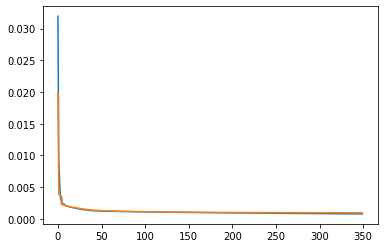

In [168]:
plt.plot(fit_hist.history['loss'])
plt.plot(fit_hist.history['val_loss'])
plt.show()

In [169]:
predict = model.predict(X_test)

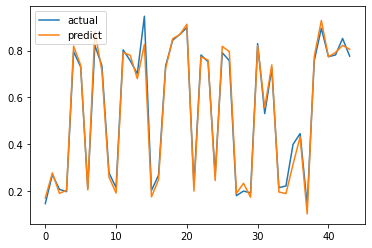

In [170]:
plt.plot(Y_test, label='actual')
plt.plot(predict, label='predict')
plt.legend()
plt.show()

## 만든 모델로 오늘의 삼성전자 주가 예측하기

In [171]:
#최근 2달간의 데이터만 사용해본다

test_data = raw_data['2021-04-15' : '2021-06-14'][['Open', 'High', 'Low', 'Close', 'Volume']]
print(test_data.head())
print(test_data.info())
print(test_data.shape)

               Open     High      Low    Close      Volume
Date                                                      
2021-04-15  83700.0  84500.0  83400.0  84100.0  16377412.0
2021-04-16  84700.0  84700.0  83600.0  83900.0  15429522.0
2021-04-19  83800.0  84000.0  83300.0  83300.0  15287311.0
2021-04-20  83300.0  84000.0  83100.0  83900.0  15521965.0
2021-04-21  83300.0  83500.0  82500.0  82600.0  21636079.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40 entries, 2021-04-15 to 2021-06-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    40 non-null     float64
 1   High    40 non-null     float64
 2   Low     40 non-null     float64
 3   Close   40 non-null     float64
 4   Volume  40 non-null     float64
dtypes: float64(5)
memory usage: 1.9 KB
None
(40, 5)


In [172]:
#데이터 스케일링 

scaled_test_data = minmaxscaler.transform(test_data)  #transform은 학습 데이터에서 설정된 변환을 위한 기반 설정을 그대로 테스트 데이터에도 적용하기 위해서
# 학습 데이터 세트로 fit() 된 Scaler를 이용하여 테스트 데이터를 변환할 경우에는  테스트 데이터에서 다시 fit()하지 않고 반드시 그대로 이 Scaler를 이용하여 transform()을 수행해야 한다
print(scaled_test_data[-5:])
print(scaled_test_data.shape)

[[0.8056266  0.6875     0.80050505 0.77858881 0.08858503]
 [0.79539642 0.68303571 0.80555556 0.77858881 0.0427121 ]
 [0.77493606 0.66964286 0.78787879 0.75912409 0.06898393]
 [0.76982097 0.65625    0.78282828 0.756691   0.10205434]
 [0.76726343 0.66294643 0.77777778 0.756691   0.05884784]]
(40, 5)


In [173]:
scaled_test_data[39][3]  #임의의 날짜로 종가 출력해보기, 이때 스케일링이 된 상태라 종가가 얼마인지 알아볼 수 없다

0.75669099756691

In [174]:
#스케일링 된 데이터를 다시 변환시켜서 원가 확인해보기

predict_value = minmaxscaler.inverse_transform(scaled_test_data[39].reshape(-1, 5)) #inverse_transform= 위 문제를 해결하기 위해 원래 값으로 되돌리라는 것
print(predict_value)

[[   81200.    81700.    80700.    81000. 14087962.]]


In [175]:
print(test_data.iloc[39])

Open         81200.0
High         81700.0
Low          80700.0
Close        81000.0
Volume    14087962.0
Name: 2021-06-11 00:00:00, dtype: float64


In [176]:
#데이터 스케일링, feature, target 시퀀스화

sequence_testdata_X = []
sequence_testdata_Y = []
for i in range(len(scaled_test_data) - 28):
    _x = scaled_test_data[i : i + 28]
    _y = scaled_test_data[i+28][3]
    sequence_testdata_X.append(_x)
    sequence_testdata_Y.append(_y)

#ndarray로 변환
sequence_testdata_X = np.array(sequence_testdata_X)
sequence_testdata_Y = np.array(sequence_testdata_Y)

print(sequence_testdata_X.shape)
print(sequence_testdata_Y.shape)

(12, 28, 5)
(12,)


In [177]:
#최근 2달데이터로 예측하기

predict = model.predict(sequence_testdata_X)

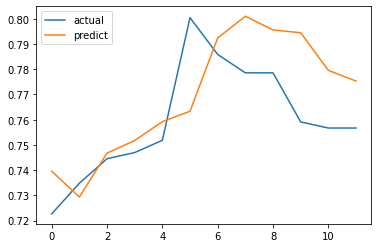

In [178]:
#그래프로 나타내기

plt.plot(sequence_testdata_Y, label='actual')
plt.plot(predict, label='predict')
plt.legend()

In [179]:
last_28_data = scaled_test_data[-28:]  #last_28_data = 가장 최신 데이터를 가져와서 오늘 것을 예측하기
last_28_data.shape

(28, 5)

In [180]:
#5개의 컬럼에 맞춰서 reshape
last_28_data = last_28_data.reshape(-1, 28, 5)
last_28_data.shape

(1, 28, 5)

In [181]:
#최신 데이터로 오늘 주식 종가 예측하기
today_close = model.predict(last_28_data)
print(today_close)

[[0.77943236]]


In [182]:
#종가만 스케일링해주는 스케일러를 만들어주기(위에는 5개의 컬럼을 다 넣고 스케일링을 만든거라 여기서 사용불가)

minmaxscaler_close = MinMaxScaler()
_ = minmaxscaler_close.fit_transform(data[['Close']])  #data= 2019-06 ~ 2020-06 데이터
today_close = minmaxscaler_close.inverse_transform(today_close)
print(today_close)

[[81934.664]]
